<h1> DS200A Computer Vision Assignment</h1>

In [180]:
import seaborn as sns

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import sklearn
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC

from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier


from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [181]:
features = pd.read_pickle('./features_flattened.pkl') 

In [182]:
train = features.drop(["categories","label"], axis=1)
train.head()

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,195816,2.426829,183.355727,56.406650,176.750337,64.039966,149.151581,79.648356,166.791454,53.495949,...,38,398,340,266,3819,-194.894118,4.385381e-15,0.513160,121.392454,125.92
1,221352,2.179348,210.739822,55.293247,189.280101,74.486619,164.805242,70.417988,181.672576,56.847182,...,52,413,207,203,1817,-34.841830,-1.143882e+02,0.842771,115.469323,160.38
2,194535,2.381818,170.123787,64.391428,147.788681,68.085443,111.753798,89.914294,145.131762,56.089846,...,25,392,466,317,3755,178.556863,3.996803e-14,0.227126,93.911721,142.00
3,200430,2.311765,152.159752,64.525514,132.648316,62.769907,77.917303,83.412773,129.573314,53.570175,...,32,396,575,382,5270,-252.338562,2.062941e+02,0.212932,110.053966,126.54
4,208560,2.244318,147.397886,73.855439,150.504790,71.385855,86.252963,94.391311,138.168607,62.001119,...,36,407,592,431,4616,-380.200000,-2.003953e-14,0.247828,114.599032,99.30


<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [183]:
def train_test_split(df, labels):
    ss= StandardScaler()
    df_stand = ss.fit_transform(df.values)
    X= df_stand
    y=labels
#     y = features['label'].values

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.2, random_state=42)
    y_train=y_train.astype('int')
    y_test = y_test.astype('int')
    return X_train, X_test, y_train, y_test
#Split the data into a training set, and test set 

In [184]:
def pred_accuracy(name_string, model):
        # generate predictions
    y_pred = model.predict(X_test)

    # calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(name_string+ " " +'Model accuracy is: ', accuracy)
    return accuracy

In [185]:
def compute_accuracy(model, X_train, Y_train):
    # Computes mean of 5 cross validation on accuracy
    
    '''
    Split the training data into 5 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the accuracy on that subset (the validation set)
    Return the average MSE of these 5 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation accuracy for the 5 splits.
    '''
    kf = KFold(n_splits=5)
    validation_accuracy = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train[train_idx] , X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train[train_idx] , Y_train[valid_idx]
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        accuracy = accuracy_score(split_Y_valid, model.predict(split_X_valid))


        validation_accuracy.append(accuracy)
        
    return np.mean(validation_accuracy)

In [186]:
def findMinDiff(arr): 
    #Returns minimum difference of an array and its index
    # Initialize difference as infinite 
    diff = 10**20
    index = []
      
    # Find the min diff by comparing difference 
    # of all possible pairs in given array 
    for i in range(0,len(arr)): 
        for j in range(i+1,len(arr)): 
            if abs(arr[i]-arr[j]) < diff: 
                diff = abs(arr[i] - arr[j]) 
                index = [i+1,j+1]
  
    # Return min diff 
    return diff, index

In [187]:
def findMaxDiff(arr): 
    #Returns maximum difference of an array and its index
    # Initialize difference as infinite 
    diff = 0
    index=[]
      
    # Find the min diff by comparing difference 
    # of all possible pairs in given array 
    for i in range(13,len(arr)): 
        for j in range(i+1,len(arr)): 
            if abs(arr[i]-arr[j]) > diff: 
                diff = abs(arr[i] - arr[j])    
                index = [i+1,j+1]
                
  
    # Return max diff 
    return diff, index

In [188]:
X_train, X_test, y_train, y_test=train_test_split(train, features['label'].values)

<h3> SVM

In [189]:
# This code computes 5 fold cross validation on an SVM where it is trained
# on models with each successive feature. Finds how many features will result
# in the highest accuracy, and predicts on the test set with a model that is 
# trained on the optimal number of features


svm = SVC()
range_of_num_features = range(1,X_train.shape[1]+1)
accuracy_SVM=[]
for N in range_of_num_features:
    print(f"Trying first {N} features")   
    # compute the cross validation accuracy
    accuracy = compute_accuracy(svm, X_train[:,:N],y_train)
    
    print("\tAccuracy:", accuracy)
    accuracy_SVM.append(accuracy)

best_num_features_SVM = np.argmax(accuracy_SVM) + 1
best_accuracy_SVM = accuracy_SVM[best_num_features_SVM-1]

# Fit SVM Model
svm.fit(X_train[:, :best_num_features_SVM], y_train)

# Predict points from the test set and calculate the accuracy
test_accuracy_SVM = accuracy_score(y_test, svm.predict(X_test[:, :best_num_features_SVM]))

# Minimum increase in accuracy
diff, index = findMinDiff(accuracy_SVM)
diff_max, index_max = findMaxDiff(accuracy_SVM)

print("SVM best number of features", best_num_features_SVM)
print("KFold Validation Accuracy", best_accuracy_SVM)
print("SVM Test Accuracy", test_accuracy_SVM)
print("Minimum increase in accuracy is from features: ", index)
print("Maximum increase in accuracy is from features: ", index_max)

Trying first 1 features
	Accuracy: 0.17083333333333334
Trying first 2 features
	Accuracy: 0.22000000000000003
Trying first 3 features
	Accuracy: 0.29333333333333333
Trying first 4 features
	Accuracy: 0.2916666666666667
Trying first 5 features
	Accuracy: 0.29500000000000004
Trying first 6 features
	Accuracy: 0.3125
Trying first 7 features
	Accuracy: 0.33166666666666667
Trying first 8 features
	Accuracy: 0.3308333333333333
Trying first 9 features
	Accuracy: 0.32666666666666666
Trying first 10 features
	Accuracy: 0.32333333333333336
Trying first 11 features
	Accuracy: 0.31916666666666665
Trying first 12 features
	Accuracy: 0.31999999999999995
Trying first 13 features
	Accuracy: 0.33916666666666667
Trying first 14 features
	Accuracy: 0.34249999999999997
Trying first 15 features
	Accuracy: 0.34249999999999997
Trying first 16 features
	Accuracy: 0.34833333333333333
Trying first 17 features
	Accuracy: 0.36333333333333334
Trying first 18 features
	Accuracy: 0.36083333333333334
Trying first 19 

In [190]:
#Final SVM model
svm = SVC(kernel='linear', C=10,probability=True, random_state=42)
#C=1: Accuracy 0.0.40863787375415284
#C=10: Accuracy 0.42857142857142855
#C=50: Accuracy 0.40863787375415284
#C=100: Accuracy 0.4019933554817276

# SVM Gaussian Model accuracy is:  0.39867109634551495
# SVM Sigmoid Model accuracy is:  0.30564784053156147
# SVM Poly Model accuracy is:  0.20930232558139536

# fit model
svm.fit(X_train, y_train)
pred_accuracy('SVM', svm)

SVM Model accuracy is:  0.42857142857142855


0.42857142857142855

<h3>KNN

In [191]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred_accuracy("KNN",knn)

KNN Model accuracy is:  0.34551495016611294


0.34551495016611294

In [192]:
range_of_num_features = range(1,X_train.shape[1]+1)
accuracy_KNN=[]
for N in range_of_num_features:
    print(f"Trying first {N} features")   
    # compute the cross validation accuracy
    accuracy = compute_accuracy(knn, X_train[:,:N],y_train)
    
    print("\tAccuracy:", accuracy)
    accuracy_KNN.append(accuracy)

best_num_features_KNN = np.argmax(accuracy_KNN) + 1
best_accuracy_KNN = accuracy_KNN[best_num_features_KNN-1]

# Fit KNN Model
knn.fit(X_train[:, :best_num_features_KNN], y_train)

# Predict points from the test set and calculate the accuracy
test_accuracy_KNN = accuracy_score(y_test, knn.predict(X_test[:, :best_num_features_KNN]))

# Minimum increase in accuracy
diff_min, index_min = findMinDiff(accuracy_KNN)
diff_max, index_max = findMaxDiff(accuracy_KNN)

print("KNN best number of features", best_num_features_KNN)
print("KFold Validation Accuracy", best_accuracy_KNN)
print("KNN Test Accuracy", test_accuracy_KNN)
print("Minimum increase in accuracy is from features: ", index_min)
print("Maximum increase in accuracy is from features: ", index_max)

Trying first 1 features
	Accuracy: 0.19833333333333333
Trying first 2 features
	Accuracy: 0.23166666666666663
Trying first 3 features
	Accuracy: 0.25
Trying first 4 features
	Accuracy: 0.26
Trying first 5 features
	Accuracy: 0.25166666666666665
Trying first 6 features
	Accuracy: 0.2541666666666667
Trying first 7 features
	Accuracy: 0.2633333333333333
Trying first 8 features
	Accuracy: 0.27749999999999997
Trying first 9 features
	Accuracy: 0.2733333333333333
Trying first 10 features
	Accuracy: 0.27166666666666667
Trying first 11 features
	Accuracy: 0.2675
Trying first 12 features
	Accuracy: 0.2783333333333334
Trying first 13 features
	Accuracy: 0.2816666666666666
Trying first 14 features
	Accuracy: 0.275
Trying first 15 features
	Accuracy: 0.2816666666666666
Trying first 16 features
	Accuracy: 0.26833333333333337
Trying first 17 features
	Accuracy: 0.2975
Trying first 18 features
	Accuracy: 0.29999999999999993
Trying first 19 features
	Accuracy: 0.3
Trying first 20 features
	Accuracy: 0

In [193]:
n_neighbors= np.arange(1,20)
accuracies=[]
for n in n_neighbors:
    kn= KNeighborsClassifier(n_neighbors=n)
    kn.fit(X_train, y_train)
    train_pred = kn.predict(X_train)
#     print(n)
    n = pred_accuracy("KNN",kn)
    accuracies.append(n)

KNN Model accuracy is:  0.2956810631229236
KNN Model accuracy is:  0.2724252491694352
KNN Model accuracy is:  0.3089700996677741
KNN Model accuracy is:  0.32558139534883723
KNN Model accuracy is:  0.34551495016611294
KNN Model accuracy is:  0.3388704318936877
KNN Model accuracy is:  0.3687707641196013
KNN Model accuracy is:  0.3754152823920266
KNN Model accuracy is:  0.38205980066445183
KNN Model accuracy is:  0.38205980066445183
KNN Model accuracy is:  0.37209302325581395
KNN Model accuracy is:  0.36212624584717606
KNN Model accuracy is:  0.36212624584717606
KNN Model accuracy is:  0.3687707641196013
KNN Model accuracy is:  0.3554817275747508
KNN Model accuracy is:  0.36212624584717606
KNN Model accuracy is:  0.3654485049833887
KNN Model accuracy is:  0.3521594684385382
KNN Model accuracy is:  0.34551495016611294


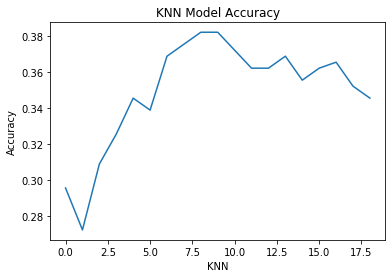

In [194]:
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.xlabel("KNN")
plt.title("KNN Model Accuracy")
plt.show()


In [195]:
#Final KNN
knn = KNeighborsClassifier(n_neighbors=10,p=2)
knn.fit(X_train, y_train)
pred_accuracy("KNN",knn)

KNN Model accuracy is:  0.38205980066445183


0.38205980066445183

<h3> Logistic Regression

In [197]:
range_of_num_features = range(1,X_train.shape[1]+1)
accuracy_LR=[]
for N in range_of_num_features:
    print(f"Trying first {N} features")   
    # compute the cross validation accuracy
    accuracy = compute_accuracy(logisticRegr, X_train[:,:N],y_train)
    
    print("\tAccuracy:", accuracy)
    accuracy_LR.append(accuracy)

best_num_features_LR = np.argmax(accuracy_LR) + 1
best_accuracy_LR = accuracy_LR[best_num_features_LR-1]

# Fit Logistic Regression Model
logisticRegr.fit(X_train[:, :best_num_features_LR], y_train)

# Predict points from the test set and calculate the accuracy
test_accuracy_LR = accuracy_score(y_test, logisticRegr.predict(X_test[:, :best_num_features_LR]))

# Minimum increase in accuracy
diff, index = findMinDiff(accuracy_LR)
diff_max, index_max = findMaxDiff(accuracy_LR)

print("Logistic Regression best number of features", best_num_features_LR)
print("KFold Validation Accuracy", best_accuracy_LR)
print("Logistic Regression Test Accuracy", test_accuracy_LR)
print("Minimum increase in accuracy is from features: ", index)
print("Maximum increase in accuracy is from features: ", index_max)

Trying first 1 features
	Accuracy: 0.18166666666666664
Trying first 2 features
	Accuracy: 0.2333333333333333
Trying first 3 features
	Accuracy: 0.29
Trying first 4 features
	Accuracy: 0.2983333333333333
Trying first 5 features
	Accuracy: 0.315
Trying first 6 features
	Accuracy: 0.33083333333333337
Trying first 7 features
	Accuracy: 0.345
Trying first 8 features
	Accuracy: 0.3516666666666667
Trying first 9 features
	Accuracy: 0.3516666666666667
Trying first 10 features
	Accuracy: 0.36583333333333334
Trying first 11 features
	Accuracy: 0.36583333333333334
Trying first 12 features
	Accuracy: 0.3616666666666667
Trying first 13 features
	Accuracy: 0.3616666666666667
Trying first 14 features
	Accuracy: 0.37583333333333335
Trying first 15 features
	Accuracy: 0.3825
Trying first 16 features
	Accuracy: 0.38416666666666666
Trying first 17 features
	Accuracy: 0.4083333333333333
Trying first 18 features
	Accuracy: 0.40166666666666667
Trying first 19 features
	Accuracy: 0.3991666666666666
Trying fi

In [198]:
logisticRegr = LogisticRegression(C=5,penalty='l1')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=10,penalty='l1')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=20,penalty='l1')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=25,penalty='l1')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=30,penalty='l1')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

Logistic Model accuracy is:  0.3920265780730897
Logistic Model accuracy is:  0.3953488372093023
Logistic Model accuracy is:  0.4053156146179402
Logistic Model accuracy is:  0.40863787375415284
Logistic Model accuracy is:  0.4053156146179402


0.4053156146179402

In [199]:
logisticRegr = LogisticRegression(C=5,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=10,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=15,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=20,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=25,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

logisticRegr = LogisticRegression(C=30,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

Logistic Model accuracy is:  0.38870431893687707
Logistic Model accuracy is:  0.4053156146179402
Logistic Model accuracy is:  0.40863787375415284
Logistic Model accuracy is:  0.4152823920265781
Logistic Model accuracy is:  0.4152823920265781
Logistic Model accuracy is:  0.4119601328903654


0.4119601328903654

In [201]:
#Final Logistic Regression

logisticRegr = LogisticRegression(C=20,penalty='l2')
logisticRegr.fit(X_train, y_train)
pred_accuracy("Logistic",logisticRegr)

Logistic Model accuracy is:  0.4152823920265781


0.4152823920265781

<h3> Classification Tree
    

In [179]:
range_of_num_features = range(1,X_train.shape[1]+1)
accuracy_dtc=[]
for N in range_of_num_features:
    print(f"Trying first {N} features")   
    # compute the cross validation accuracy
    accuracy = compute_accuracy(dtc, X_train[:,:N],y_train)
    
    print("\tAccuracy:", accuracy)
    accuracy_dtc.append(accuracy)

best_num_features_dtc = np.argmax(accuracy_dtc) + 1
best_accuracy_dtc = accuracy_dtc[best_num_features_dtc-1]

# Fit Classification Tree Model
dtc.fit(X_train[:, :best_num_features_dtc], y_train)

# Predict points from the test set and calculate the accuracy
test_accuracy_dtc = accuracy_score(y_test, dtc.predict(X_test[:, :best_num_features_dtc]))

# Minimum increase in accuracy
diff, index = findMinDiff(accuracy_dtc)
diff_max, index_max = findMaxDiff(accuracy_dtc)


print("Classification Tree best number of features", best_num_features_dtc)
print("KFold Validation Accuracy", best_accuracy_dtc)
print("Classification Tree Test Accuracy", test_accuracy_dtc)
print("Minimum increase in accuracy is from features: ", index)
print("Maximum increase in accuracy is from features: ", index_max)

Trying first 1 features
	Accuracy: 0.19166666666666668
Trying first 2 features
	Accuracy: 0.26583333333333337
Trying first 3 features
	Accuracy: 0.29083333333333333
Trying first 4 features
	Accuracy: 0.29
Trying first 5 features
	Accuracy: 0.28250000000000003
Trying first 6 features
	Accuracy: 0.2866666666666667
Trying first 7 features
	Accuracy: 0.3175
Trying first 8 features
	Accuracy: 0.31999999999999995
Trying first 9 features
	Accuracy: 0.31999999999999995
Trying first 10 features
	Accuracy: 0.32416666666666666
Trying first 11 features
	Accuracy: 0.3075
Trying first 12 features
	Accuracy: 0.3083333333333333
Trying first 13 features
	Accuracy: 0.3083333333333333
Trying first 14 features
	Accuracy: 0.31
Trying first 15 features
	Accuracy: 0.31
Trying first 16 features
	Accuracy: 0.3066666666666667
Trying first 17 features
	Accuracy: 0.30500000000000005
Trying first 18 features
	Accuracy: 0.3016666666666667
Trying first 19 features
	Accuracy: 0.29833333333333334
Trying first 20 featu

In [202]:
#Final DTC

dtc = DecisionTreeClassifier(max_depth=16,min_samples_leaf=.04)
dtc = dtc.fit(X_train, y_train)
pred_accuracy("Decision Tree",dtc)

Decision Tree Model accuracy is:  0.30564784053156147


0.30564784053156147

<h3> Random Forest

In [203]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_accuracy("RFM",rf)

RFM Model accuracy is:  0.3488372093023256


0.3488372093023256

In [204]:
#Trying Recursive Feature Elimination for Feature Selection

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [205]:
pred_accuracy("RF w RFE",rfecv)

RF w RFE Model accuracy is:  0.3023255813953488


0.3023255813953488

In [206]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

accuracies = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    accuracy = accuracy_score(y_train, train_pred)
    accuracies.append(accuracy)
#     print(estimator)
    n= pred_accuracy("RFM",rf)
    accuracies.append(n)

RFM Model accuracy is:  0.2823920265780731
RFM Model accuracy is:  0.2757475083056478
RFM Model accuracy is:  0.292358803986711
RFM Model accuracy is:  0.29900332225913623
RFM Model accuracy is:  0.33554817275747506
RFM Model accuracy is:  0.3754152823920266
RFM Model accuracy is:  0.4119601328903654
RFM Model accuracy is:  0.4318936877076412
RFM Model accuracy is:  0.43853820598006643


In [207]:
#Visualize if desired
# plt.plot(accuracies)
# plt.ylabel("Accuracy")
# plt.xlabel("RFM")
# plt.title("RFM iter n_estimators Model Accuracy")
# plt.show()

In [208]:
#Final RFM
rf = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=42, max_features=5)
rf.fit(X_train, y_train)
pred_accuracy("RFM",rf)

RFM Model accuracy is:  0.42524916943521596


0.42524916943521596

<h3> Best Model on Val Set

In [209]:
pred_accuracy('SVM', svm)
pred_accuracy("KNN",knn)
pred_accuracy("Decision Tree",dtc)
pred_accuracy("RFM",rf)
pred_accuracy("Logistic",logisticRegr)

SVM Model accuracy is:  0.42857142857142855
KNN Model accuracy is:  0.38205980066445183
Decision Tree Model accuracy is:  0.30564784053156147
RFM Model accuracy is:  0.42524916943521596
Logistic Model accuracy is:  0.4152823920265781


0.4152823920265781

In [210]:
#Train best model
best = SVC(kernel='linear', C=10,probability=True, random_state=42)
best = best.fit(X_train, y_train)

In [211]:
#Load in val set
val = pd.read_pickle('./val_features.pkl') 
val.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,38530,-182.307190,54.364706,0.387165,136.623414,259.62
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,8127,-737.857516,117.811765,0.409045,106.985920,351.28


In [212]:
ss= StandardScaler()
val_stand = ss.fit_transform(val.values)

In [213]:
# predict and save results
test_prediction = best.predict(val_stand)

In [214]:
test_prediction

array([19,  1, 15,  9, 19, 14,  8,  9,  5,  2,  9, 17,  3, 11,  3, 19, 18,
       13, 16, 17,  4, 19,  4, 14,  5,  8,  9,  5, 13, 17, 14,  8, 13,  7,
       16, 17, 13, 17, 17,  5, 14,  9,  8, 17,  5,  6, 17,  9, 16, 13, 14,
        4,  4,  7, 13,  4,  9,  9, 13, 13,  9,  9, 15,  9, 11,  5, 15,  8,
       10, 16, 17,  9,  9,  9, 15, 10,  5, 16, 14, 17, 16,  2,  4,  9, 16,
       18,  1, 16,  5,  2, 14,  3,  3,  3,  3, 17, 14,  3, 14,  9,  9,  3,
        3,  3, 14,  3,  3,  3, 11,  3, 12,  4,  9, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12,  8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 12,
       12, 12, 12, 12, 12, 12, 12,  1, 12,  1, 14, 18,  3,  9,  9,  9, 14,
       14, 10, 15,  9,  9, 17, 13,  2,  5,  4,  7, 18,  7,  5, 17, 15, 16,
       14, 13, 18,  9,  5, 13,  7, 10, 19, 13, 13, 13,  9, 10, 14, 13, 10,
       14, 10,  1,  9, 19,  4, 13, 13,  8, 13,  9,  9, 13,  1,  1,  9, 15,
        9, 18, 13,  5,  5,  9,  9,  9,  9,  6,  1,  6,  0,  0,  2,  0,  0,
        0, 14, 14,  0,  0

In [217]:
pd.DataFrame(test_prediction).to_csv('./predictions.csv', index=False, header=False)